# Homework 5 - Subset selection & shrinkage methods

In this assignment, you will explore model comparison and regularization techniques using the [ISLP Hitters](https://islp.readthedocs.io/en/latest/datasets/Hitters.html) dataset. The dataset contains season-level statistics for professional baseball players, along with their Salary (the output you will model).

**Learning goals**
- Use best subset selection to find the best predictors to keep (variable selection), using model comparison metrics such as **AIC**, **BIC**, **$C_p$**, and **adj-$R^2$**.
- See how increasing the number of predictors $k$ affects model comparison metrics.
- Compare coefficients across **OLS**, **ridge**, **lasso**, **elastic-net**.
- Use **cross-validation** to choose optimal $\lambda$ for regularization (and $\alpha$ for elastic-net).

## 1) Imports

In [1]:
# Core scientific stack
import numpy as np
import pandas as pd
import itertools
import warnings
warnings.filterwarnings('ignore')  # keep output tidy; feel free to remove

# Statsmodels for OLS + information criteria
import statsmodels.api as sm

# scikit-learn for ML models and CV
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Plotting
import matplotlib.pyplot as plt

# Reproducibility
RNG_SEED = 42
np.random.seed(RNG_SEED)

## 2) Data loading & cleaning

**Dataset**: We will be exploring the ISLP/ISLR *Hitters* baseball dataset, which records Major League Baseball Data from the 1986 and 1987 seasons.

Our output variable is is `Salary`. However, we will use $\log(\text{Salary})$, because a few baseball players earn a lot of money, which leads to a right tail in the distribution.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


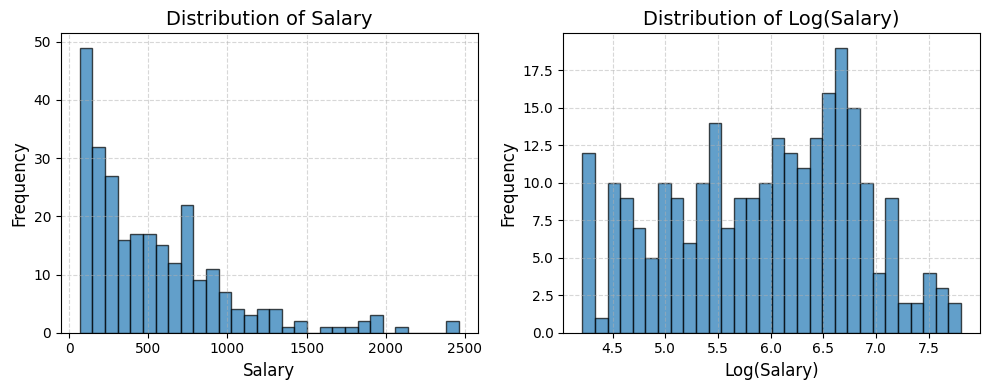

In [2]:
# Try loading via ISLP if available; otherwise fall back to a local CSV.
!pip install -q ISLP statsmodels scikit-learn pandas numpy matplotlib
from ISLP import load_data
hitters = load_data('Hitters')  # DataFrame

# Drop rows with missing Salary
hitters = hitters.dropna(subset=['Salary']).copy()
# Consider log-transforming the response: log(Salary) because a few baseball players earn a lot which leads to a right tail in the distribution
hitters['logSalary'] = np.log(hitters['Salary'])

plt.figure(figsize=(10,4))

# Left plot: raw Salary
plt.subplot(1, 2, 1)
plt.hist(hitters['Salary'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Salary', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Salary', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

# Right plot: log(Salary)
plt.subplot(1, 2, 2)
plt.hist(hitters['logSalary'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Log(Salary)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Log(Salary)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


**Sanity EDA (very light)**

In [3]:
# Quick description of the first 10 numeric variables
hitters.describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
AtBat,263.0,403.642586,147.307209,19.0,282.5,413.0,526.0,687.0
Hits,263.0,107.828897,45.125326,1.0,71.5,103.0,141.5,238.0
HmRun,263.0,11.619772,8.757108,0.0,5.0,9.0,18.0,40.0
Runs,263.0,54.745247,25.539816,0.0,33.5,52.0,73.0,130.0
RBI,263.0,51.486692,25.882714,0.0,30.0,47.0,71.0,121.0
Walks,263.0,41.114068,21.718056,0.0,23.0,37.0,57.0,105.0
Years,263.0,7.311787,4.793616,1.0,4.0,6.0,10.0,24.0
CAtBat,263.0,2657.543726,2286.582929,19.0,842.5,1931.0,3890.5,14053.0
CHits,263.0,722.186312,648.199644,4.0,212.0,516.0,1054.0,4256.0
CHmRun,263.0,69.239544,82.197581,0.0,15.0,40.0,92.5,548.0


In [4]:
# Identify predictors: use all columns except Salary and player name id columns if present.
# Build X with get_dummies; drop_first=True to avoid multicollinearity.
# Define features (X) and output (y)
X = hitters.drop(columns=['Salary', 'logSalary'])
X = pd.get_dummies(X, drop_first=True, dtype=float)
y = hitters['logSalary'].astype(float)

# compute correlation of each feature with outcome and pick the top 10
corrs = X.corrwith(y)

# get top correlations by absolute value
top_corrs = corrs.abs().sort_values(ascending=False)

# display both coefficient and direction
top_corrs_full = corrs.loc[top_corrs.index]
print(top_corrs_full)


# we are only taking the top 10 predictors so that subset selection doesn't take forever to run
X_top10 = hitters.loc[:, corrs.abs().sort_values(ascending=False).head(10).index]

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_top10, y, test_size=0.2, random_state=RNG_SEED
)

X_train.shape, X_test.shape

CRuns          0.621089
CHits          0.619941
CAtBat         0.610800
CRBI           0.602671
CWalks         0.546581
Years          0.537371
CHmRun         0.523943
Hits           0.449584
RBI            0.444150
Walks          0.432439
Runs           0.425596
AtBat          0.414946
HmRun          0.339854
PutOuts        0.224483
Division_W    -0.150098
Assists        0.049969
Errors        -0.020765
NewLeague_N   -0.010404
League_N      -0.006443
dtype: float64


((210, 10), (53, 10))

## 3) Baseline Full OLS model (Train) + Test MSE

We are going to first fit an OLS linear regression model with *all* predictors to compute $\hat{\sigma}^2_{\text{full}}$ for $C_p$, and to get a baseline test error.


In [5]:
# Add intercept manually via statsmodels helper
Xtr_full = sm.add_constant(X_train, has_constant='add')
Xte_full = sm.add_constant(X_test,  has_constant='add')

# Train/fit the OLS model
ols_full = sm.OLS(y_train, Xtr_full).fit()
print(ols_full.summary().tables[1])  # coefficients table

# Sigma^2_full from train residuals
n_train = int(ols_full.nobs)
p_full  = int(ols_full.df_model) + 1  # parameters incl. intercept
RSS_full = float(ols_full.ssr)
sigma2_full = RSS_full / (n_train - p_full)

# Baseline test MSE
y_pred_full_test = ols_full.predict(Xte_full) # Generate predictions from the trained model
full_test_mse = mean_squared_error(y_test, y_pred_full_test) # Compute a regression error metric

sigma2_full, p_full, full_test_mse

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2411      0.166     25.549      0.000       3.914       4.568
CRuns          0.0008      0.001      0.547      0.585      -0.002       0.004
CHits          0.0005      0.001      0.399      0.690      -0.002       0.003
CAtBat        -0.0002      0.000     -0.683      0.496      -0.001       0.000
CRBI           0.0003      0.001      0.193      0.847      -0.003       0.003
CWalks        -0.0006      0.001     -0.939      0.349      -0.002       0.001
Years          0.0821      0.027      3.001      0.003       0.028       0.136
CHmRun        -0.0002      0.003     -0.047      0.962      -0.007       0.006
Hits           0.0058      0.002      2.847      0.005       0.002       0.010
RBI            0.0014      0.003      0.409      0.683      -0.005       0.008
Walks          0.0076      0.004      2.110      0.0

(0.39570867059015336, 11, 0.4233645898463973)

## 4) Best subset selection

We are now going to use best subset selection to find the best combination of variables per $k$ predictors.

We’ll evaluate **all** $\binom{p}{k}$ combinations for $k=1,\dots,k_{\max}$ (feasible if predictors $p$ is moderate). For each subset, we fit an OLS on the **training** data and compute AIC, BIC, $C_p$, $R^2$, adj-$R^2$. Then we keep the *best* subset at each $k$ according to each criterion.


In [6]:
feature_names = X_train.columns.tolist()
d = len(feature_names)

# We will collect rows for every combo of predictors, then find the best model for that k (k = number of predictors)
rows = []

for k in range(1, 10):
    for combo in itertools.combinations(feature_names, k):
        # Build design matrices with just this subset + intercept
        Xtr_k = sm.add_constant(X_train.loc[:, list(combo)], has_constant='add')
        Xte_k = sm.add_constant(X_test.loc[:, list(combo)],  has_constant='add')

        # Fit OLS
        res = sm.OLS(y_train, Xtr_k).fit()

        # Extract metrics
        n = int(res.nobs) # data points
        p = int(res.df_model) + 1  # predictors

        # Extract model assessment and selection metrics
        RSS = float(res.ssr)
        R2 = float(res.rsquared)
        adjR2 = float(res.rsquared_adj)
        AIC = float(res.aic)
        BIC = float(res.bic)
        Cp  = RSS / sigma2_full - (n - 2 * p)  # Mallow's Cp

        # test MSE for this subset
        y_pred_te = res.predict(Xte_k)
        test_mse = mean_squared_error(y_test, y_pred_te)

        rows.append({
            'k': k,
            'subset': combo,
            'AIC': AIC,
            'BIC': BIC,
            'Cp': Cp,
            'R2': R2,
            'adjR2': adjR2,
            'train_RSS': RSS,
            'train_MSE': RSS / (n - p),
            'test_MSE': test_mse
        })

subset_df = pd.DataFrame(rows)
subset_df.head()

# The table below shows k (the number of predictors), the subset (variables fit in the k=1 models) and a variety of model comparison metrics. b
# Best subset selection uses one of the metrics to choose the best model within k=1. Then, best subset selection moves onto k=2, etc.

,k,subset,AIC,BIC,Cp,R2,adjR2,train_RSS,train_MSE,test_MSE
0,1,"(CRuns,)",454.788143,461.482358,59.846131,0.391986,0.389062,105.197619,0.505758,0.416004
1,1,"(CHits,)",454.467828,461.162044,59.440943,0.392912,0.389994,105.037283,0.504987,0.424704
2,1,"(CAtBat,)",456.673647,463.367862,62.243802,0.386502,0.383552,106.146398,0.510319,0.448384
3,1,"(CRBI,)",459.025884,465.720099,65.265327,0.379591,0.376609,107.342042,0.516068,0.464203
4,1,"(CWalks,)",481.276733,487.970948,95.585582,0.310246,0.306930,119.340030,0.573750,0.491271


**Find the best subset at each k (number of predictors) under each model selection criterion**

Now that we've run the model for many combos of predictors, we can store the best model for each $k$ according to the different model selection metrics.

Take a peak at how different metrics end up with different combos of predictors for each $k$!

In [7]:
best_by_k_AIC = subset_df.loc[subset_df.groupby('k')['AIC'].idxmin()].reset_index(drop=True)
best_by_k_BIC = subset_df.loc[subset_df.groupby('k')['BIC'].idxmin()].reset_index(drop=True)
best_by_k_Cp  = subset_df.loc[subset_df.groupby('k')['Cp'].idxmin()].reset_index(drop=True)
best_by_k_R2    = subset_df.loc[subset_df.groupby('k')['R2'].idxmax()].reset_index(drop=True)
best_by_k_adjR2 = subset_df.loc[subset_df.groupby('k')['adjR2'].idxmax()].reset_index(drop=True)
best_by_k_testMSE   = subset_df.loc[subset_df.groupby('k')['test_MSE'].idxmax()].reset_index(drop=True)

best_by_k_AIC.head() # showing the table of best models ranked by AIC
# each row is the best model for k number of predictors, and the subset of those predictors is shown in the 2nd column.

,k,subset,AIC,BIC,Cp,R2,adjR2,train_RSS,train_MSE,test_MSE
0,1,"(CHits,)",454.467828,461.162044,59.440943,0.392912,0.389994,105.037283,0.504987,0.424704
1,2,"(Years, Hits)",406.128083,416.169405,4.863161,0.522311,0.517696,82.648964,0.399270,0.477069
2,3,"(Years, Hits, Walks)",402.398018,415.786448,1.241166,0.535169,0.528400,80.424292,0.390409,0.455008
3,4,"(CHits, Years, Hits, Walks)",402.465426,419.200964,1.379355,0.539427,0.530440,79.687557,0.388720,0.432782
4,5,"(CRuns, CWalks, Years, Hits, Walks)",403.154648,423.237293,2.126299,0.542293,0.531075,79.191712,0.388195,0.422137


**Plot: metric vs k (best subsets only)**

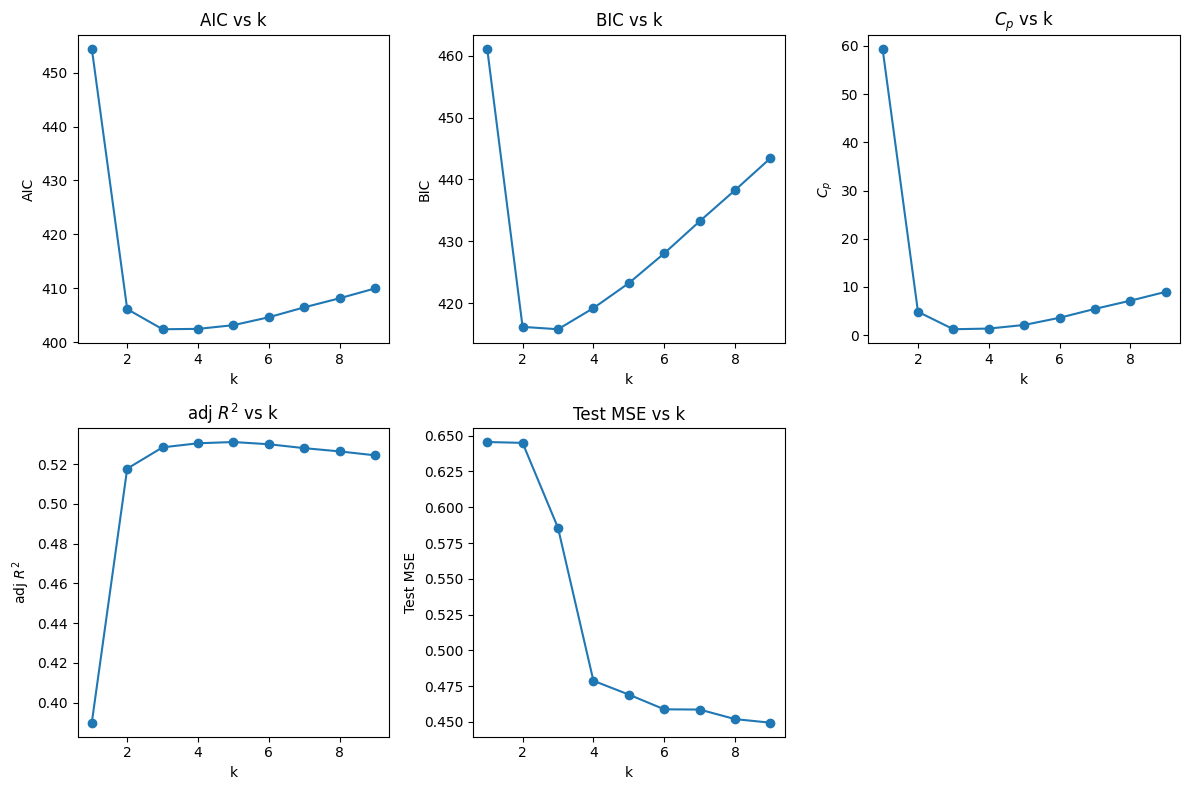

In [8]:
plt.figure(figsize=(12,8))

ax1 = plt.subplot(2,3,1)
plt.plot(best_by_k_AIC['k'], best_by_k_AIC['AIC'], marker='o')
plt.xlabel('k'); plt.ylabel('AIC'); plt.title('AIC vs k')

ax2 = plt.subplot(2,3,2)
plt.plot(best_by_k_BIC['k'], best_by_k_BIC['BIC'], marker='o')
plt.xlabel('k'); plt.ylabel('BIC'); plt.title('BIC vs k')

ax3 = plt.subplot(2,3,3)
plt.plot(best_by_k_Cp['k'], best_by_k_Cp['Cp'], marker='o')
plt.xlabel('k'); plt.ylabel("$C_p$"); plt.title('$C_p$ vs k')

ax4 = plt.subplot(2,3,4)
plt.plot(best_by_k_adjR2['k'], best_by_k_adjR2['adjR2'], marker='o')
plt.xlabel('k'); plt.ylabel('adj $R^2$'); plt.title('adj $R^2$ vs k')

ax5 = plt.subplot(2,3,5)
plt.plot(best_by_k_testMSE['k'], best_by_k_testMSE['test_MSE'], marker='o')
plt.xlabel('k'); plt.ylabel('Test MSE'); plt.title('Test MSE vs k')

plt.tight_layout(); plt.show()

**Pick the globally “best” OLS models according to each criterion**

In [9]:
best_AIC_row = best_by_k_AIC.loc[best_by_k_AIC['AIC'].idxmin()]
best_BIC_row = best_by_k_BIC.loc[best_by_k_BIC['BIC'].idxmin()]
best_Cp_row  = best_by_k_Cp.loc[best_by_k_Cp['Cp'].idxmin()]

## 5) Fit the data on the best models & inspect coefficients

Refit each chosen subset on the training data, then evaluate on test.
Compare the coefficients between models.


In [10]:
records = []
coefs_tables = {}

for label, row in [('Best-AIC', best_AIC_row), ('Best-BIC', best_BIC_row), ('Best-Cp', best_Cp_row)]:
    subset = list(row['subset'])
    Xtr = sm.add_constant(X_train.loc[:, subset], has_constant='add')
    Xte = sm.add_constant(X_test.loc[:, subset],  has_constant='add')
    res = sm.OLS(y_train, Xtr).fit()

    yhat_tr = res.predict(Xtr)
    yhat_te = res.predict(Xte)

    rec = {
        'Model': label,
        'k': len(subset),
        'AIC': float(res.aic),
        'BIC': float(res.bic),
        'R2': float(res.rsquared),
        'adjR2': float(res.rsquared_adj),
        'Train_MSE': mean_squared_error(y_train, yhat_tr),
        'Test_MSE': mean_squared_error(y_test, yhat_te)
    }
    records.append(rec)

    # Store coefficients neatly
    coef_series = res.params.copy()
    coef_series.name = label
    coefs_tables[label] = coef_series

ols_summary_df = pd.DataFrame(records)
ols_summary_df


,Model,k,AIC,BIC,R2,adjR2,Train_MSE,Test_MSE
0,Best-AIC,3,402.398018,415.786448,0.535169,0.5284,0.382973,0.455008
1,Best-BIC,3,402.398018,415.786448,0.535169,0.5284,0.382973,0.455008
2,Best-Cp,3,402.398018,415.786448,0.535169,0.5284,0.382973,0.455008


In [11]:
# Combine coefficients from each OLS model into a single wide table
ols_coefs_df = pd.concat(coefs_tables.values(), axis=1).fillna(0.0)
ols_coefs_df.head(20)

# The below table shows the final coefficient values for the 3 parameters that were selected by best subset selection.
# Notice that the parameter values are the same for all three model selection methods!

,Best-AIC,Best-BIC,Best-Cp
const,4.108502,4.108502,4.108502
Years,0.099864,0.099864,0.099864
Hits,0.007870,0.007870,0.007870
Walks,0.006105,0.006105,0.006105


## 6) Shrinkage Methods with Cross-Validation (Ridge, Lasso, Elastic-Net)

Now, we are going to use ridge regression, lasso, and elastic net to fit our model. But first, we need to standardize our predictors so that they are all in the same range [0,1]. This is important because regularization heavily depends on feature scale. We’ll use `Pipeline(StandardScaler(), Model)` so the model sees standardized features.

Then, we are going to use cross-validation to determine the best lambda value (the one that gives the lowest CV error) for our models.

For parameter interpretability, we’ll **convert the fitted coefficients back to the original feature scale** after fitting:

- If $X_{\text{std}} = (X - \mu)/\sigma$ and the model is $y = b_0' + \sum_j b_j' X_{\text{std},j}$, then in the original scale: $\beta_j = b_j'/\sigma_j$, $\beta_0 = b_0' - \sum_j (b_j'\,\mu_j/\sigma_j)$.


In [12]:
# Common CV setup
cv = KFold(n_splits=10, shuffle=True, random_state=RNG_SEED)

# We are going to try out a range of values for lambda (alpha in sklearn)
ridge_alphas = np.logspace(-4, 4, 200)
lasso_alphas = np.logspace(-4, 1, 200)
enet_alphas  = np.logspace(-4, 1, 120)
l1_grid = [0.1, 0.3, 0.5, 0.7, 0.9]

# 1) Ridge regression
# Create a preprocessing + model pipeline to fit all the ridge regression models with different lambdas
ridge_pipe = Pipeline([
    ('scaler', StandardScaler(with_mean=True, with_std=True)), # Standardize features to zero mean and unit variance
    ('model', RidgeCV(alphas=ridge_alphas, cv=cv, fit_intercept=True))  # Configure the strength/type of regularization
])
# Train/fit the model on the provided data
ridge_pipe.fit(X_train, y_train)

# Extract standardized coefs
ridge_model = ridge_pipe.named_steps['model']
scaler = ridge_pipe.named_steps['scaler']

b_std = ridge_model.coef_
b0_std = ridge_model.intercept_
mu = scaler.mean_
sigma = scaler.scale_

# Final coefficients for ridge regression
beta_ridge = b_std / sigma
beta0_ridge = b0_std - np.sum(b_std * mu / sigma)

# Model predictions and train / test errors
yhat_tr_ridge = ridge_pipe.predict(X_train)
yhat_te_ridge = ridge_pipe.predict(X_test)

ridge_best_alpha = ridge_model.alpha_
ridge_train_mse = mean_squared_error(y_train, yhat_tr_ridge)
ridge_test_mse = mean_squared_error(y_test, yhat_te_ridge)

# 2) Lasso
# Create a preprocessing + model pipeline to fit all the lasso models with different lambdas
lasso_pipe = Pipeline([
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('model', LassoCV(alphas=lasso_alphas, cv=cv, fit_intercept=True, max_iter=20000, random_state=RNG_SEED))
])
lasso_pipe.fit(X_train, y_train)

lasso_model = lasso_pipe.named_steps['model']
scaler = lasso_pipe.named_steps['scaler']

b_std = lasso_model.coef_
b0_std = lasso_model.intercept_
mu = scaler.mean_
sigma = scaler.scale_

# Final coefficients for lasso
beta_lasso = b_std / sigma
beta0_lasso = b0_std - np.sum(b_std * mu / sigma)

# Model predictions and train / test errors
yhat_tr_lasso = lasso_pipe.predict(X_train)
yhat_te_lasso = lasso_pipe.predict(X_test)

lasso_best_alpha = lasso_model.alpha_
lasso_train_mse = mean_squared_error(y_train, yhat_tr_lasso)
lasso_test_mse = mean_squared_error(y_test, yhat_te_lasso)
lasso_nonzero = int(np.sum(np.abs(beta_lasso) > 1e-8))

# 3) ElasticNet
# Create a preprocessing + model pipeline to fit all the lasso models with different lambdas
enet_pipe = Pipeline([
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('model', ElasticNetCV(l1_ratio=l1_grid, alphas=enet_alphas, cv=cv, fit_intercept=True, max_iter=20000, random_state=RNG_SEED))
])
enet_pipe.fit(X_train, y_train)

enet_model = enet_pipe.named_steps['model']
scaler = enet_pipe.named_steps['scaler']

b_std = enet_model.coef_
b0_std = enet_model.intercept_
mu = scaler.mean_
sigma = scaler.scale_

# Final coefficients for elastic net
beta_enet = b_std / sigma
beta0_enet = b0_std - np.sum(b_std * mu / sigma)

# Predictions and errors
yhat_tr_enet = enet_pipe.predict(X_train)
yhat_te_enet = enet_pipe.predict(X_test)

enet_best_alpha = float(enet_model.alpha_)
enet_best_l1ratio = float(enet_model.l1_ratio_)
enet_train_mse = mean_squared_error(y_train, yhat_tr_enet)
enet_test_mse = mean_squared_error(y_test, yhat_te_enet)
enet_nonzero = int(np.sum(np.abs(beta_enet) > 1e-8))

# Print the best lambda/alpha parameters determined by cross-validation
print("Ridge regression, best lambda:", ridge_best_alpha)
print("Lasso, best lambda:", lasso_best_alpha)
print("ElasticNet, best alpha:", enet_best_alpha)
print("ElasticNet, best L1 ratio:", enet_best_l1ratio)

Ridge regression, best lambda: 67.475440531107
Lasso, best lambda: 0.03072112998861759
ElasticNet, best alpha: 0.12860080806105664
ElasticNet, best L1 ratio: 0.1


## 7) Comparing OLS vs Shrinkage methods

We are now going to compare our vanilla OLS model to the regularized models (ridge, lasso, and elastic net).


In [13]:
# Gather OLS rows from earlier summary + shrinkage models here
comp_rows = []

# Include baseline Full OLS as well
comp_rows.append({
    'Model': 'Full-OLS',
    'k': X_train.shape[1],
    'AIC': float(ols_full.aic),
    'BIC': float(ols_full.bic),
    'R2': float(ols_full.rsquared),
    'adjR2': float(ols_full.rsquared_adj),
    'Train_MSE': mean_squared_error(y_train, ols_full.predict(Xtr_full)),
    'Test_MSE': full_test_mse,
    'lambda': np.nan,
    'alpha_EN': np.nan,
    '#nonzero': X_train.shape[1]
})

for _, r in ols_summary_df.iterrows():
    comp_rows.append({
        'Model': r['Model'],
        'k': int(r['k']),
        'AIC': float(r['AIC']),
        'BIC': float(r['BIC']),
        'R2': float(r['R2']),
        'adjR2': float(r['adjR2']),
        'Train_MSE': float(r['Train_MSE']),
        'Test_MSE': float(r['Test_MSE']),
        'lambda': np.nan,
        'alpha_EN': np.nan,
        '#nonzero': int(r['k'])
    })

# Shrinkage rows
comp_rows.append({
    'Model': 'Ridge-CV',
    'k': X_train.shape[1],
    'AIC': np.nan,
    'BIC': np.nan,
    'R2': np.nan,
    'adjR2': np.nan,
    'Train_MSE': ridge_train_mse,
    'Test_MSE': ridge_test_mse,
    'lambda': ridge_best_alpha,
    'alpha_EN': np.nan,
    '#nonzero': X_train.shape[1]  # ridge keeps all
})

comp_rows.append({
    'Model': 'Lasso-CV',
    'k': X_train.shape[1],
    'AIC': np.nan,
    'BIC': np.nan,
    'R2': np.nan,
    'adjR2': np.nan,
    'Train_MSE': lasso_train_mse,
    'Test_MSE': lasso_test_mse,
    'lambda': lasso_best_alpha,
    'alpha_EN': np.nan,
    '#nonzero': lasso_nonzero
})

comp_rows.append({
    'Model': 'ElasticNet-CV',
    'k': X_train.shape[1],
    'AIC': np.nan,
    'BIC': np.nan,
    'R2': np.nan,
    'adjR2': np.nan,
    'Train_MSE': enet_train_mse,
    'Test_MSE': enet_test_mse,
    'lambda': enet_best_alpha,
    'alpha_EN': enet_best_l1ratio,
    '#nonzero': enet_nonzero
})

comp_df = pd.DataFrame(comp_rows)
comp_df

# The table below shows the models we have fit using best subset selection (Best-) and regularization with cross-validation (RidgeCV, LassoCV, and ElasticNetCV)
# along with several model selection metrics. The last column shows the number of non-zero parameters.

,Model,k,AIC,BIC,R2,adjR2,Train_MSE,Test_MSE,lambda,alpha_EN,#nonzero
0,Full-OLS,10,411.969442,448.787625,0.544869,0.521998,0.374981,0.423365,NaN,NaN,10
1,Best-AIC,3,402.398018,415.786448,0.535169,0.528400,0.382973,0.455008,NaN,NaN,3
2,Best-BIC,3,402.398018,415.786448,0.535169,0.528400,0.382973,0.455008,NaN,NaN,3
3,Best-Cp,3,402.398018,415.786448,0.535169,0.528400,0.382973,0.455008,NaN,NaN,3
4,Ridge-CV,10,NaN,NaN,NaN,NaN,0.389066,0.405976,67.475441,NaN,10
5,Lasso-CV,10,NaN,NaN,NaN,NaN,0.380487,0.417471,0.030721,NaN,7
6,ElasticNet-CV,10,NaN,NaN,NaN,NaN,0.383605,0.411373,0.128601,0.1,8


**Bar plots: Test MSE and number of selected predictors**

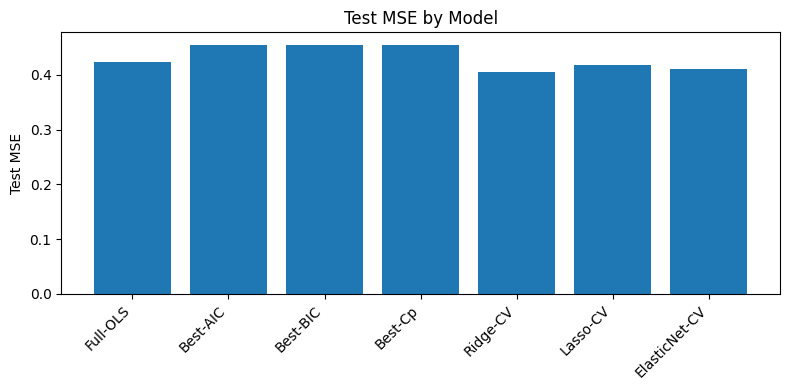

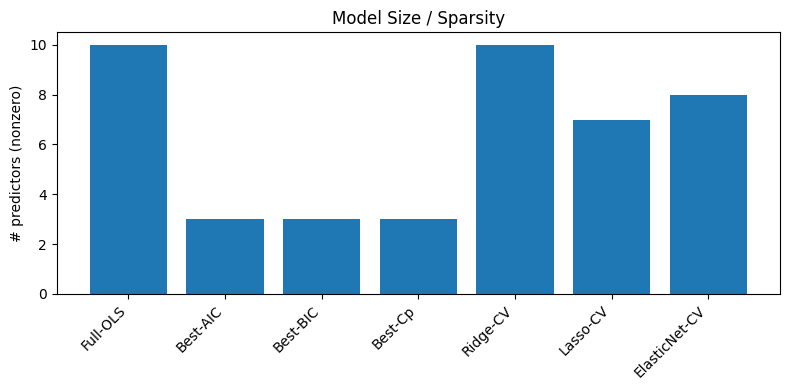

In [14]:
# Test MSE bar plot
plt.figure(figsize=(8,4))
plt.bar(comp_df['Model'], comp_df['Test_MSE'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Test MSE')
plt.title('Test MSE by Model')
plt.tight_layout(); plt.show()

# Predictors bar plot
plt.figure(figsize=(8,4))
plt.bar(comp_df['Model'], comp_df['#nonzero'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('# predictors (nonzero)')
plt.title('Model Size / Sparsity')
plt.tight_layout(); plt.show()

**Coefficient tables (original scale)**

In [15]:
# Assemble shrinkage coefficients into a DataFrame (match OLS columns for easy compare)
coef_df = pd.DataFrame(index=['const'] + X_train.columns.tolist())

# OLS models
for name, series in coefs_tables.items():
    coef_df[name] = series.reindex(coef_df.index).fillna(0.0)

# Full OLS
full_series = ols_full.params.copy(); full_series.name = 'Full-OLS'
coef_df['Full-OLS'] = full_series.reindex(coef_df.index).fillna(0.0)

# Shrinkage (already converted to original scale)
coef_df['Ridge-CV'] = pd.Series({'const': beta0_ridge, **dict(zip(X_train.columns, beta_ridge))}).reindex(coef_df.index).fillna(0.0)
coef_df['Lasso-CV'] = pd.Series({'const': beta0_lasso, **dict(zip(X_train.columns, beta_lasso))}).reindex(coef_df.index).fillna(0.0)
coef_df['ElasticNet-CV'] = pd.Series({'const': beta0_enet, **dict(zip(X_train.columns, beta_enet))}).reindex(coef_df.index).fillna(0.0)

(coef_df
 .reindex(coef_df.index)                    # keep order
 .assign(abs_max=lambda d: d.abs().max(axis=1))
 .sort_values('abs_max', ascending=False)
 .drop(columns='abs_max')
 .head(20)
 .style.format('{:.3e}'))


,Best-AIC,Best-BIC,Best-Cp,Full-OLS,Ridge-CV,Lasso-CV,ElasticNet-CV
const,4.109e+00,4.109e+00,4.109e+00,4.241e+00,4.575e+00,4.390e+00,4.480e+00
Years,9.986e-02,9.986e-02,9.986e-02,8.206e-02,2.782e-02,5.752e-02,3.876e-02
Hits,7.870e-03,7.870e-03,7.870e-03,5.792e-03,4.037e-03,5.902e-03,4.870e-03
Walks,6.105e-03,6.105e-03,6.105e-03,7.596e-03,4.417e-03,4.635e-03,4.593e-03
RBI,0.000e+00,0.000e+00,0.000e+00,1.399e-03,3.426e-03,1.778e-03,2.856e-03
CRuns,0.000e+00,0.000e+00,0.000e+00,7.603e-04,2.287e-04,4.678e-05,2.075e-04
CWalks,0.000e+00,0.000e+00,0.000e+00,-6.380e-04,5.312e-05,0.000e+00,0.000e+00
CHits,0.000e+00,0.000e+00,0.000e+00,5.080e-04,1.402e-04,2.418e-04,1.461e-04
CRBI,0.000e+00,0.000e+00,0.000e+00,2.824e-04,1.795e-04,4.046e-05,1.341e-04
CAtBat,0.000e+00,0.000e+00,0.000e+00,-1.802e-04,3.549e-05,0.000e+00,3.055e-05


## 8) Coefficients vs $\log\lambda$

* We will now visualize how the ridge and lasso coefficients change for different
values of $\lambda$ using `sklearn`'s `Ridge` and `lasso_path` packages.

* The **main idea**: ridge coefficients shrink smoothly while lasso drives some to **zero** as $\lambda$ grows.

* We plot $\log_{10} \lambda$ because Ridge and Lasso models are highly sensitive to small changes in $\lambda$. Therefore, plotting $\lambda$ directly would squash most of the interesting behavior into the small region near $\lambda=0$.

* By plotting $\log_{10} \lambda$, we “stretch out” this region and make the entire coefficient path visible across a wide range of regularization strengths.

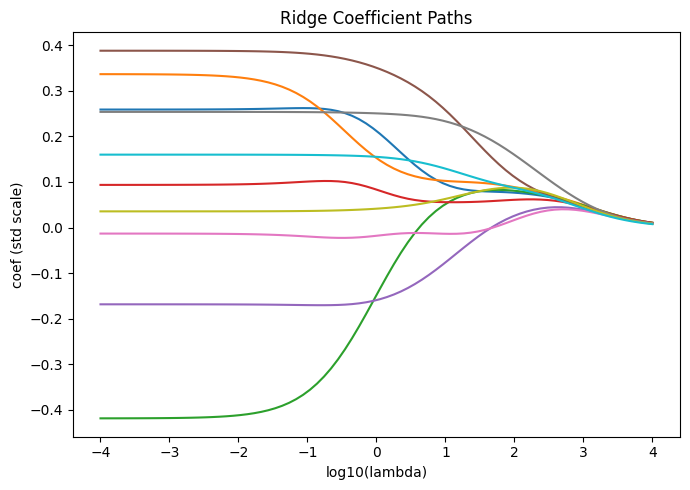

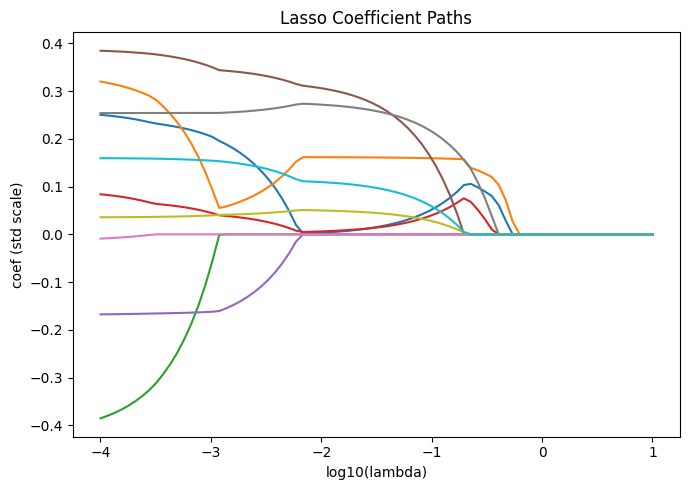

In [16]:
# WARNING: This cell can be compute-heavy for many features. Adjust grid sizes as needed.

# Prepare standardized copies so we can fit a path cleanly
scaler = StandardScaler(with_mean=True, with_std=True)
Xtr_std = scaler.fit_transform(X_train)

# Ridge path (manual sweep)
ridge_alphas_path = np.logspace(-4, 4, 80)
ridge_coefs_path = []
for a in ridge_alphas_path:
    from sklearn.linear_model import Ridge
    r = Ridge(alpha=a, fit_intercept=True)
    r.fit(Xtr_std, y_train)
    ridge_coefs_path.append(r.coef_)
ridge_coefs_path = np.array(ridge_coefs_path)

plt.figure(figsize=(7,5))
for j in range(X_train.shape[1]):
    plt.plot(np.log10(ridge_alphas_path), ridge_coefs_path[:, j])
plt.xlabel('log10(lambda)'); plt.ylabel('coef (std scale)'); plt.title('Ridge Coefficient Paths')
plt.tight_layout(); plt.show()

# Lasso path using sklearn's lasso_path util
from sklearn.linear_model import lasso_path
alphas_lasso_path, coefs_lasso_path, _ = lasso_path(Xtr_std, y_train, alphas=np.logspace(-4, 1, 80))

plt.figure(figsize=(7,5))
for j in range(coefs_lasso_path.shape[0]):
    plt.plot(np.log10(alphas_lasso_path), coefs_lasso_path[j, :])
plt.xlabel('log10(lambda)'); plt.ylabel('coef (std scale)'); plt.title('Lasso Coefficient Paths')
plt.tight_layout(); plt.show()